In [311]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [312]:
from pathlib import Path

import numpy as np
import xarray
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
import h5py
from scipy.stats import norm

from enspred.plotting import format_plot, save_plot

In [313]:
import h5py
with h5py.File("../data/z500_2013-10-06T0.h5", "r") as f:
    point1 = f["point_one"][:]
    point2 = f["point_two"][:]
    (lat1, lon1) = f["latlon1"][:]
    (lat2, lon2) = f["latlon2"][:]
    dates_string = f["dates_string"][:]

In [314]:
(lat1, lon1), (lat2, lon2)

((40, 200), (20, 200))

(array([ 4.,  0.,  5., 16., 12., 21., 15., 14.,  9.,  4.]),
 array([5825.55229039, 5831.01793451, 5836.48357862, 5841.94922273,
        5847.41486685, 5852.88051096, 5858.34615507, 5863.81179918,
        5869.2774433 , 5874.74308741, 5880.20873152]),
 <BarContainer object of 10 artists>)

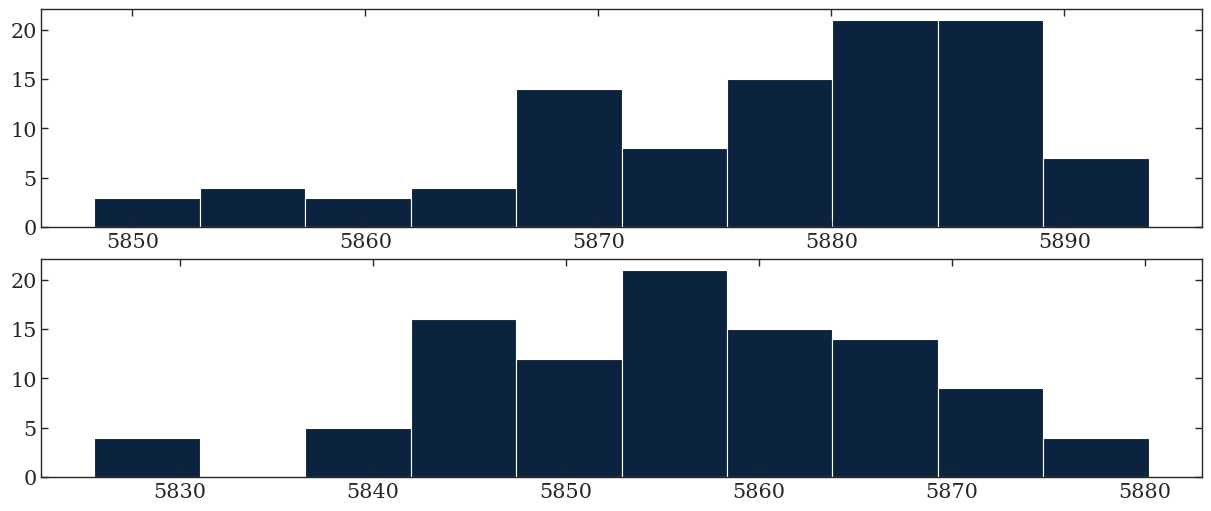

In [315]:
fig, axs = plt.subplots(2)
axs[0].hist(point1)
axs[1].hist(point2)

# Single observation

In [316]:
point1[0]

5853.880367609582

In [317]:
def assimilate(prior, y, sigma_y):
    K = prior.var() / (prior.var() + sigma_y**2)
    posterior_std = np.sqrt((1 - K) * prior.var())
    posterior_mean = prior.mean() + K * (y - prior.mean())
    posterior = norm(posterior_mean, posterior_std)
    return posterior

In [318]:
def plot_pdf(ax, dist, lim=0.0001, **kwargs):
    x = np.linspace(dist.ppf(lim), dist.ppf(1 - lim), 100)
    ax.plot(x, dist.pdf(x), **kwargs)

In [331]:
def assimilate_single_and_plot(point, lat, name):
    sigma_y = np.sqrt(10)

    x_true = point[0]
    y = x_true + norm.rvs(0, sigma_y, random_state=default_rng(int(14154567554 + point[0] + lat)))
    ensemple_prior_samples = point[1:]
    ensemble_prior = norm(*norm.fit(ensemple_prior_samples))
    ensemble_posterior = assimilate(ensemble_prior, y, sigma_y)

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.axvline(x_true, color="C2", alpha=0.5, label="True value", ls="--")
    plot_pdf(ax, ensemble_prior, label="Prior")
    plot_pdf(ax, ensemble_posterior, label="Posterior")
    plot_pdf(ax, norm(y, sigma_y), label="Observation")

    jitter_max = ax.get_ylim()[1] * 0.05
    ax.scatter(ensemple_prior_samples, np.random.uniform(0, jitter_max, ensemple_prior_samples.shape), c="C0", label="Prior samples")
    ax.scatter(y, jitter_max / 2, c="C2")

    ax.legend()
    ax.set_xlabel("Z500")
    ax.set_ylabel("Probability density")

    format_plot()
    save_plot("../latex/hw3/figures", name)

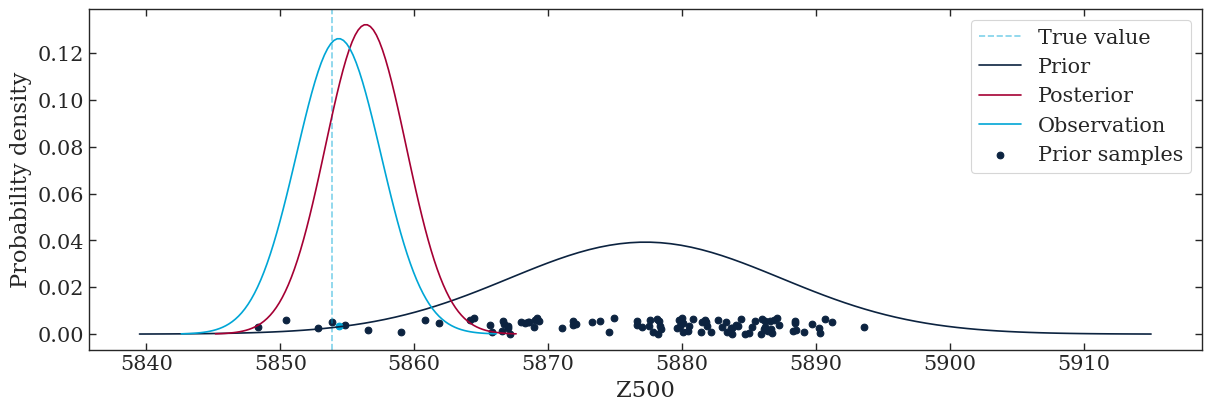

In [332]:
assimilate_single_and_plot(point1, lat1, "single_point1")

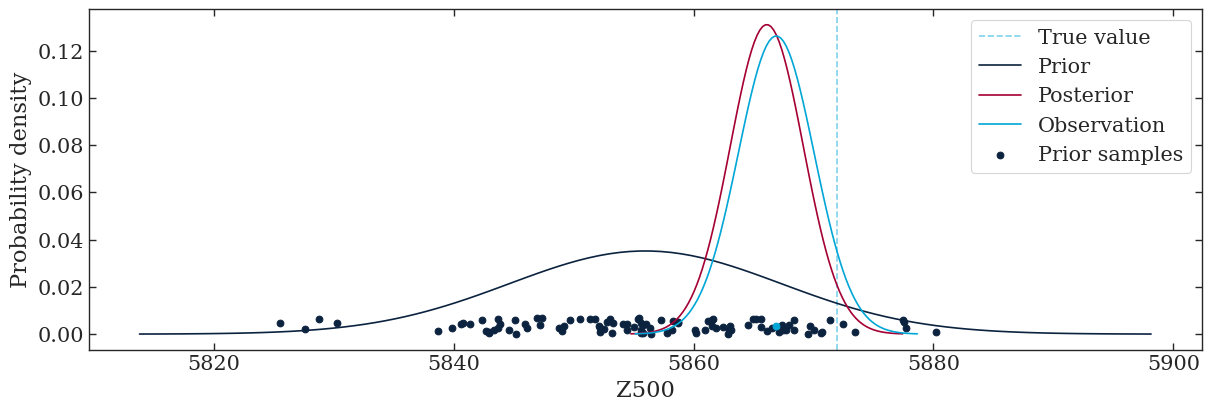

In [333]:
assimilate_single_and_plot(point2, lat2, "single_point2")

# Multiple observations

In [356]:
def assimilate_multiple(point, lat, sigma_y, seed_inc=0):
    N_obs = 100

    x_true = point[0]
    initial_prior_samples = point[1:]
    initial_prior = norm(*norm.fit(initial_prior_samples))
    prior = initial_prior

    rng = default_rng(int(14154567554 + point[0] + lat + seed_inc))
    obs = []
    posteriors = []
    for i in range(N_obs):
        y = x_true + norm.rvs(0, sigma_y, random_state=rng)
        obs.append(y)
        posterior = assimilate(prior, y, sigma_y)
        prior = posterior
        posteriors.append(posterior)

    return N_obs, x_true, initial_prior, obs, posteriors

In [357]:
def assimilate_multiple_and_plot(point, lat, sigma_y, name):
    N_obs, x_true, initial_prior, obs, posteriors = assimilate_multiple(point, lat, sigma_y)

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.axvline(x_true, color="C2", alpha=0.5, label="True value", ls="--")
    plot_pdf(ax, initial_prior, lim=0.001, label="Initial prior")

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("reds", [
        matplotlib.colors.to_rgb("white"),
        matplotlib.colors.to_rgb("C1"),
    ])(np.linspace(0.3, 1, N_obs))
    
    for i, posterior in enumerate(posteriors):
        if i < 5 or (i % 10 == 9 and i < N_obs - 1):
            if i == 49:
                label = "Intermediate posteriors"
            else:
                label = None
            plot_pdf(ax, posterior, color=cmap[i], ls=":", label=label)
    
    plot_pdf(ax, posterior, color="C1", label="Final posterior")

    jitter_max = ax.get_ylim()[1] * 0.05
    ax.scatter(obs, np.random.uniform(0, jitter_max, len(obs)), c="C2", label="Observations")

    ax.legend()
    ax.set_xlabel("Z500")
    ax.set_ylabel("Probability density")

    format_plot()
    save_plot("../latex/hw3/figures", name)

## $\sigma_y^2 = 10$

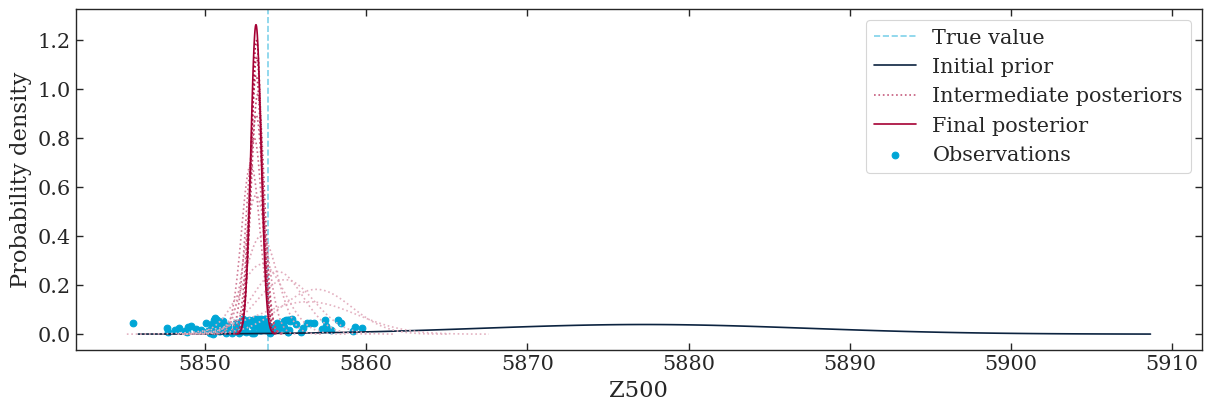

In [358]:
assimilate_multiple_and_plot(point1, lat1, np.sqrt(10), "multiple_point1_var10")

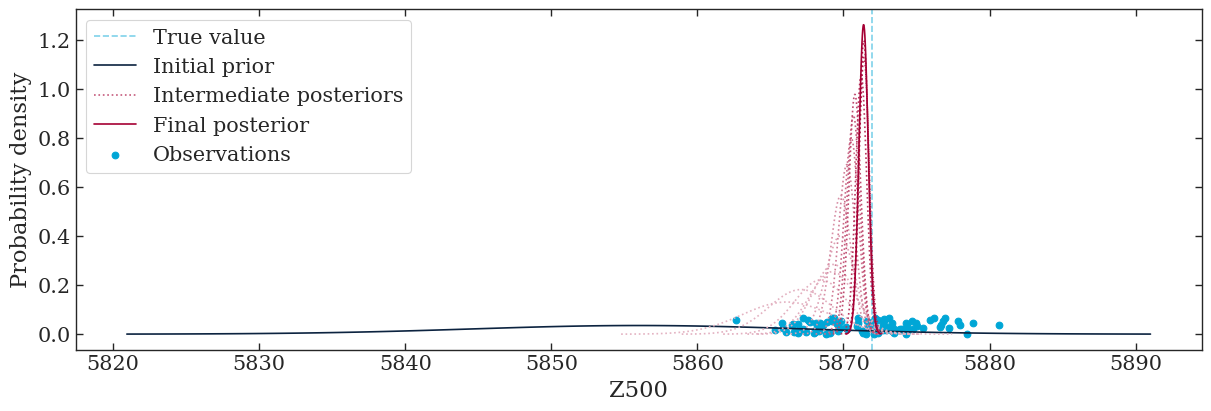

In [359]:
assimilate_multiple_and_plot(point2, lat2, np.sqrt(10), "multiple_point2_var10")

In [393]:
def compute_statistics(point, lat, sigma_y):
    errors = []
    variances = []
    for i in range(100):
        _, x_true, _, _, posteriors = \
            assimilate_multiple(point, lat, sigma_y, seed_inc=i)
        errors.append(x_true - posteriors[-1].mean())
        variances.append(posteriors[-1].var())

    print(f"Error variance of final mean: {np.var(errors)}")
    print(f"Mean variance of final posterior: {np.mean(variances)}")

In [408]:
def plot_statistics_evolution(point, lat, sigma_y, name):
    errors = []
    variances = []
    cumulative_var_of_errors = []
    cumulative_mean_vars = []

    _, x_true, _, _, posteriors = \
        assimilate_multiple(point, lat, sigma_y)
    
    for posterior in posteriors:
        errors.append(x_true - posterior.mean())
        variances.append(posterior.var())
        cumulative_var_of_errors.append(np.var(errors))
        cumulative_mean_vars.append(np.mean(variances))
    
    fig, ax = plt.subplots(figsize=(12, 4))

    xx = np.arange(len(errors)) + 1
    ax.plot(xx, cumulative_var_of_errors, label="Variance of errors")
    ax.plot(xx, cumulative_mean_vars, label="Mean variance of posteriors")

    ax.set_xlabel("Number of observations assimilated")
    ax.set_ylabel("Variance/error")
    ax.legend()

    format_plot()
    save_plot("../latex/hw3/figures", name)

Error variance of final mean: 0.10885646281110856
Mean variance of final posterior: 0.09990321510053311


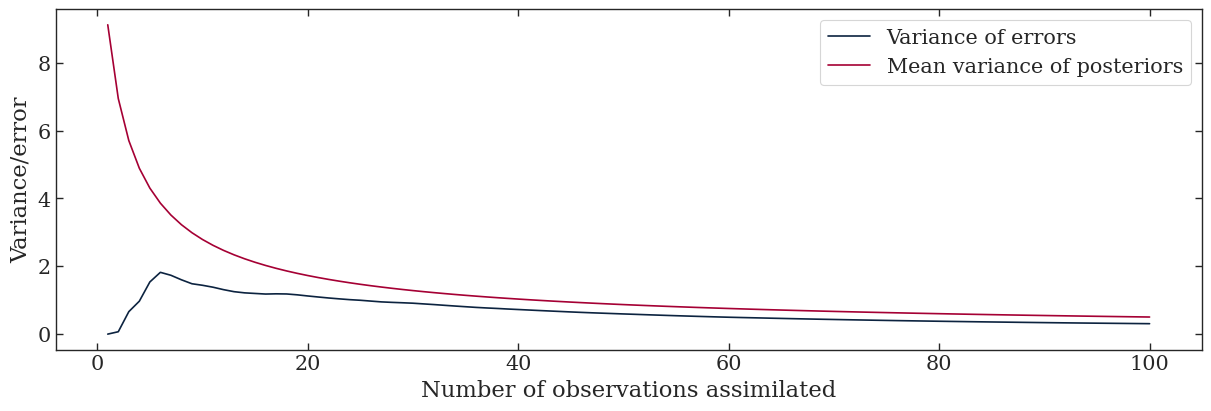

In [409]:
compute_statistics(point1, lat1, np.sqrt(10))
plot_statistics_evolution(point1, lat1, np.sqrt(10), "stats_point1_var10")

Error variance of final mean: 0.11121460025842701
Mean variance of final posterior: 0.09992225338831377


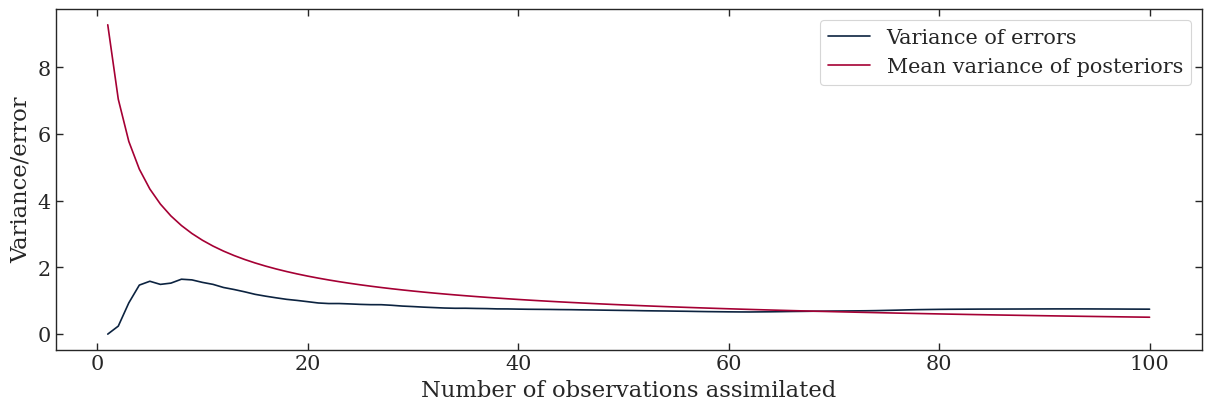

In [410]:
compute_statistics(point2, lat2, np.sqrt(10))
plot_statistics_evolution(point2, lat2, np.sqrt(10), "stats_point2_var10")

## $\sigma_y^2 = 0.01$

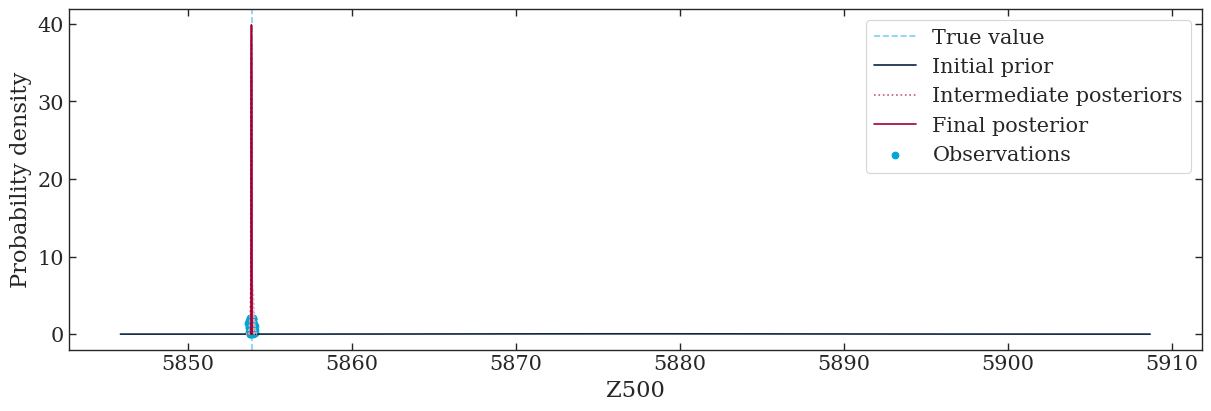

In [411]:
assimilate_multiple_and_plot(point1, lat1, np.sqrt(0.01), "multiple_point1_var01")

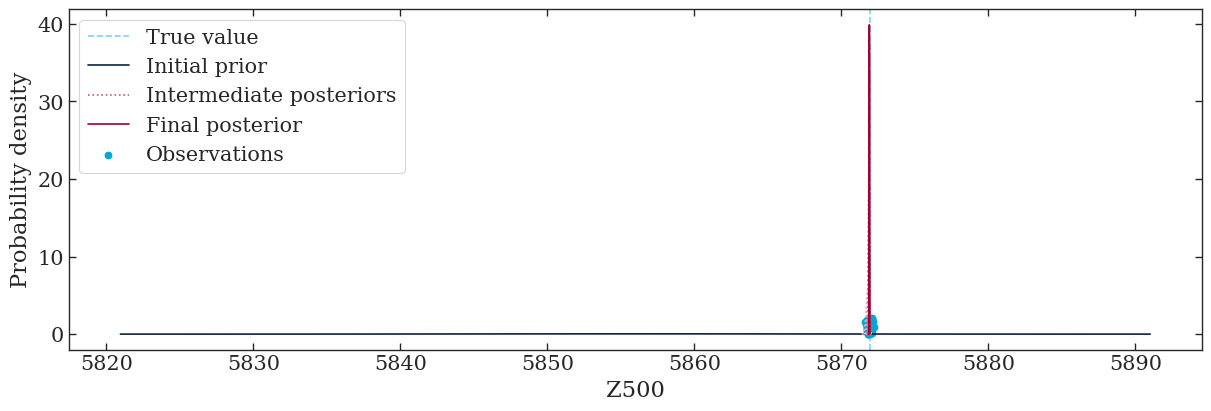

In [412]:
assimilate_multiple_and_plot(point2, lat2, np.sqrt(0.01), "multiple_point2_var01")

Error variance of final mean: 0.00010906727102024958
Mean variance of final posterior: 9.999990312143137e-05


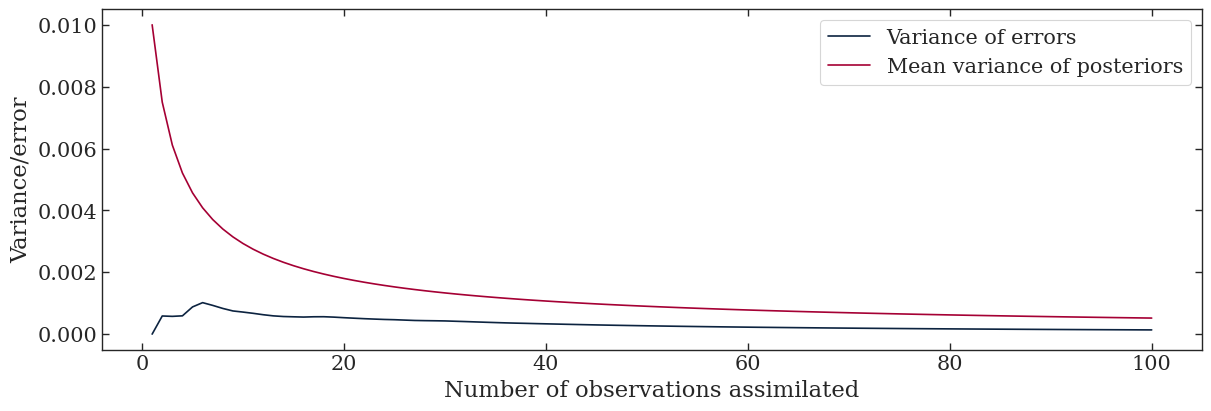

In [413]:
compute_statistics(point1, lat1, np.sqrt(0.01))
plot_statistics_evolution(point1, lat1, np.sqrt(0.01), "stats_point1_var01")

Error variance of final mean: 0.00011138755997051677
Mean variance of final posterior: 9.999992219295499e-05


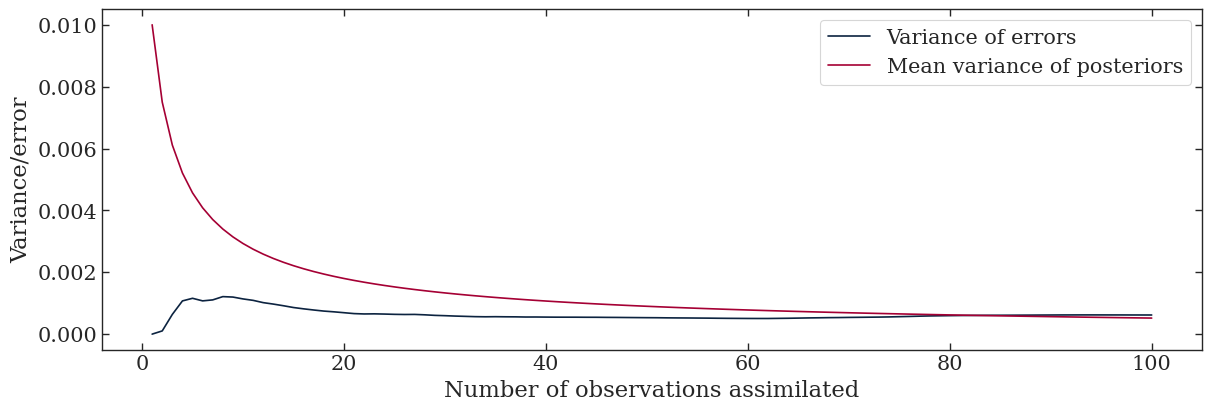

In [414]:
compute_statistics(point2, lat2, np.sqrt(0.01))
plot_statistics_evolution(point2, lat2, np.sqrt(0.01), "stats_point2_var01")